<a href="https://colab.research.google.com/github/emmazing394/TNM095-AI_for_interactive_media/blob/master/aidraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import os
from tensorflow.keras import layers
import urllib.request
import pandas as pd


In [2]:
classes = ["ant", "bee", "bird", "cat", "dog", "dolphin", "dragon", "horse", "rabbit", "swan"]

In [3]:
!mkdir data

Här kan man skriva kommentarer

In [4]:
def download():

  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')




In [5]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dolphin.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dragon.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/horse.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/swan.npy


In [10]:
def load_data(path, test_ratio=0.2, maxItemsPerClass = 6000):

  #initialize variables
  x = np.empty([0, 784])
  y = np.empty([0])
  
  files = [x for x in os.listdir(path)]

  for i, file in enumerate(files):
    data = np.load(path + "/" + file)
    data = data[0: maxItemsPerClass, :]
    labels = np.full(data.shape[0], i)

    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)

  data = None
  labels = None

  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  test_size = int(x.shape[0] / 100 * (test_ratio * 100))

  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]

  # Reshape and normalize, image size is 28x28
  #The model will take batches of the shape [N, 28, 28,1]
  #Outputs probabilities of the shape [N, 10]
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

  x_train /= 255.0
  x_test /= 255.0

  # Convert class vectors to class matrices
  num_classes = len(classes)
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return x_train, y_train, x_test, y_test


In [11]:
x_train, y_train, x_test, y_test = load_data("data")

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(48000, 28, 28, 1) (48000, 10) (12000, 28, 28, 1) (12000, 10)


In [19]:
import matplotlib.pyplot as plt
from random import randint


In [25]:
# Define model
model = keras.Sequential()
model.add(keras.layers.Convolution2D(16, (3, 3),
                        padding="same",
                        input_shape=x_train.shape[1:], activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(32, (3, 3), padding="same", activation= "relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(64, (3, 3), padding="same", activation= "relu"))
model.add(keras.layers.MaxPooling2D(pool_size =(2,2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 64)         

In [26]:
# Train the model
history = model.fit(x=x_train, y=y_train, validation_split=0.1, batch_size=32, verbose=2, epochs=10)

Epoch 1/10
1350/1350 - 38s - loss: 1.2843 - accuracy: 0.5656 - val_loss: 0.8855 - val_accuracy: 0.7165
Epoch 2/10
1350/1350 - 38s - loss: 0.8962 - accuracy: 0.7071 - val_loss: 0.7674 - val_accuracy: 0.7437
Epoch 3/10
1350/1350 - 42s - loss: 0.7999 - accuracy: 0.7365 - val_loss: 0.7102 - val_accuracy: 0.7610
Epoch 4/10
1350/1350 - 38s - loss: 0.7371 - accuracy: 0.7566 - val_loss: 0.6866 - val_accuracy: 0.7725
Epoch 5/10
1350/1350 - 38s - loss: 0.6905 - accuracy: 0.7718 - val_loss: 0.6658 - val_accuracy: 0.7812
Epoch 6/10
1350/1350 - 38s - loss: 0.6495 - accuracy: 0.7855 - val_loss: 0.6568 - val_accuracy: 0.7860
Epoch 7/10
1350/1350 - 38s - loss: 0.6240 - accuracy: 0.7935 - val_loss: 0.6488 - val_accuracy: 0.7908
Epoch 8/10
1350/1350 - 38s - loss: 0.5955 - accuracy: 0.8026 - val_loss: 0.6547 - val_accuracy: 0.7850
Epoch 9/10
1350/1350 - 37s - loss: 0.5711 - accuracy: 0.8088 - val_loss: 0.6303 - val_accuracy: 0.7931
Epoch 10/10
1350/1350 - 38s - loss: 0.5517 - accuracy: 0.8141 - val_loss:

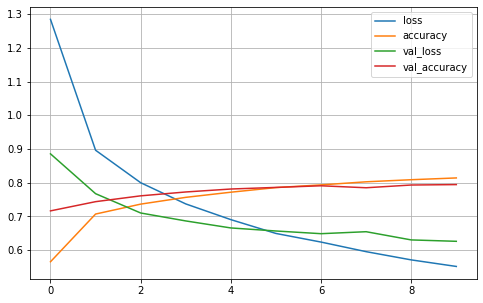

In [29]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

In [30]:
pred = model.predict(x_test)
results = model.evaluate(x_test, y_test)

print(f"After 20 epochs, the loss is {results[0]}, and the accuracy is {results[1]}")

375/375 [==============================] - 4s 11ms/step - loss: 0.6414 - accuracy: 0.7911
After 20 epochs, the loss is 0.6414353847503662, and the accuracy is 0.7910833358764648


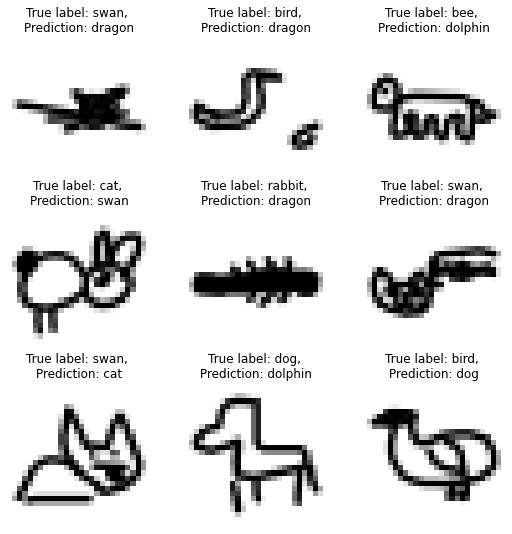

In [31]:
y_pred = np.argmax(pred, axis = 1)
y = np.argmax(y_test, axis = 1)

# Get the indices of the bad labels
bad_pred = np.argwhere((y == y_pred) == False).squeeze()

#Plot
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in enumerate(axes.flatten()):
    idx = np.random.choice(bad_pred)
    x_show = np.squeeze(x_test[idx])
    ax.imshow(x_show, cmap="gray_r", interpolation="nearest")
    ax.set_title(f"True label: {classes[y[idx]]}, \nPrediction: {classes[y_pred[idx]]}")
    ax.axis("off")

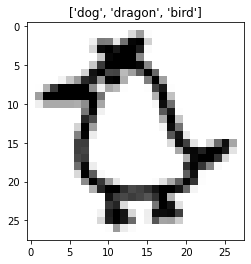

In [33]:
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze(), cmap="gray_r")
pred1 = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred1).argsort()[:3]
latex = [classes[x] for x in ind]
plt.title(latex)
plt.show()

In [34]:
with open('classes.txt', 'w') as file_handler:
    for item in classes:
        file_handler.write("{}\n".format(item))

In [35]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 1.9MB/s 


In [36]:
model.save('keras.h5')

In [37]:
!mkdir model
!tensorflowjs_converter --input_format keras.h5 model/

2020-10-11 12:39:52.531628: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tf_hub,tfjs_layers_model,tf_frozen_model,keras,tf_saved_model,keras_saved_model}]
                                       [--output_format {tfjs_graph_model,keras,keras_saved_model,tfjs_layers_model}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}]
                                       [--split_weights_by_layer] [--version]
                           

In [38]:
!cp classes.txt model/classes.txt

In [39]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/classes.txt (deflated 9%)


In [40]:
from google.colab import files 
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>